In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

# TODO: Change this to your Drive folder location
WORKING_DIRECTORY = '/content/drive/MyDrive/Anonymizer'

os.chdir(WORKING_DIRECTORY)

In [3]:
!ls

car.txt			model_autokeras_car.h5	yolov3-wider_16000.weights
coco.names		obj-license.names	yolov4.cfg
custom_license.weights	output			yolov4-obj-license.cfg
images			yolov3-face.cfg		yolov4.weights


In [ ]:
!pip install autokeras

In [8]:
import numpy as np
import autokeras as ak
import cv2
import time
import os
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import load_model
#from tensorflow.keras.models import load_model

In [5]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        print(filename)
        if img is not None:
            images.append(img)
    return images

00913.jpg
00849.jpg
01856.jpg
01635.jpg
01698.jpg
00459.jpg
00249.jpg
00183.jpg
00983.jpg
01029.jpg
01899.jpg
Total Images:  11
car
(224, 632, 3)
71
Chevrolet Monte Carlo Coupe 2007
car
(133, 272, 3)
71
Chevrolet Monte Carlo Coupe 2007
car
(193, 536, 3)
20
Audi S5 Convertible 2012
person
(206, 56, 3)
29
BMW 3 Series Wagon 2012
car
(560, 744, 3)
71
Chevrolet Monte Carlo Coupe 2007
car
(151, 409, 3)
71
Chevrolet Monte Carlo Coupe 2007
car
(168, 407, 3)
29
BMW 3 Series Wagon 2012
car
(187, 367, 3)
71
Chevrolet Monte Carlo Coupe 2007
car
(312, 592, 3)
29
BMW 3 Series Wagon 2012
person
(26, 21, 3)
185
Toyota Sequoia SUV 2012
person
(64, 69, 3)
135
Hyundai Accent Sedan 2012
person
(150, 52, 3)
174
Rolls-Royce Phantom Drophead Coupe Convertible 2012
car
(364, 625, 3)
71
Chevrolet Monte Carlo Coupe 2007
car
(224, 537, 3)
71
Chevrolet Monte Carlo Coupe 2007
car
(46, 95, 3)
29
BMW 3 Series Wagon 2012
car
(40, 63, 3)
29
BMW 3 Series Wagon 2012
car
(38, 54, 3)
29
BMW 3 Series Wagon 2012
car
(38, 4

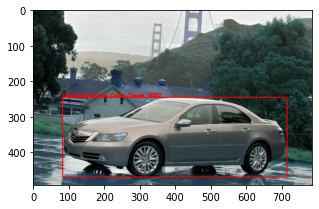

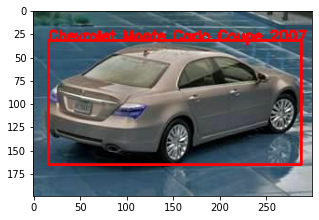

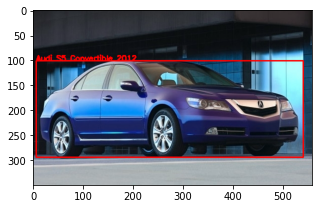

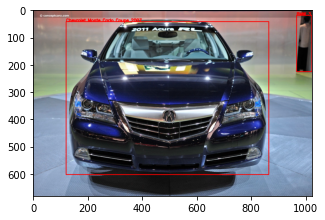

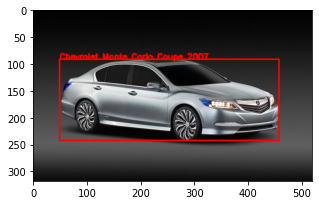

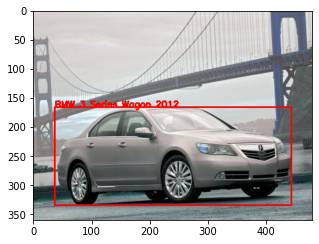

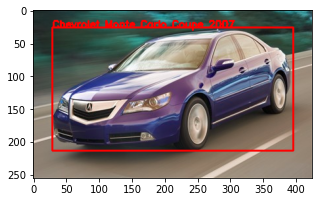

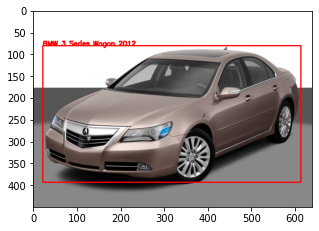

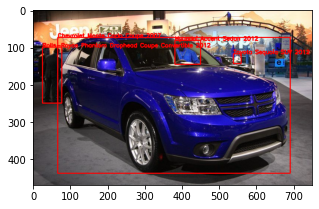

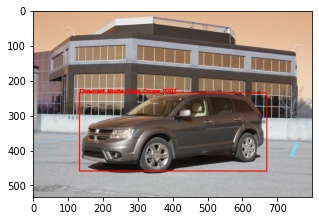

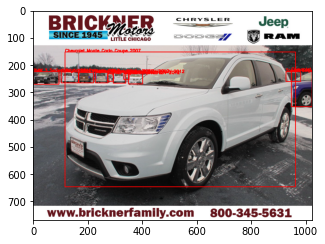

In [9]:
def main():

    input_folder_path = "images"
    output_folder_path = "output"
    all_images = load_images_from_folder(input_folder_path)
    print('Total Images: ',len(all_images))
    HEIGHT = 128
    WIDTH = 128
#cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
    net = cv2.dnn.readNet("yolov4.weights", "yolov4.cfg")
    #net = cv2.dnn.readNet("yolov4-tiny_training_last.weights", "yolov4-tiny_training.cfg")

    classes = []
    with open("coco.names", "r") as f:
        classes = [line.strip() for line in f.readlines()]
    #car=[]
    #get last layers names
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    colors = np.random.uniform(0, 255, size=(len(classes), 3))
    check_time = True
    confidence_threshold = 0.5
    font = cv2.FONT_HERSHEY_SIMPLEX



    detection_confidence = 0.5
    cap = cv2.VideoCapture(0)
    font = cv2.FONT_HERSHEY_SIMPLEX

    classification_model = load_model('model_autokeras_car.h5') #load mask detection model
    classes_classification = []
    with open("car.txt", "r") as f:
        classes_classification = [line.strip() for line in f.readlines()]

        for i in range(len(all_images)):
            img = all_images[i]
            #get image shape
            height, width, channels = img.shape
            #print(img.shape)



            # Detecting objects (YOLO)
            blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
            net.setInput(blob)
            outs = net.forward(output_layers)

            # Showing informations on the screen (YOLO)
            class_ids = []
            confidences = []
            boxes = []
            for out in outs:
                for detection in out:
                    scores = detection[5:]
                    class_id = np.argmax(scores)
                    confidence = scores[class_id]
                    if confidence > confidence_threshold:
                        # Object detected
                        center_x = int(detection[0] * width)
                        center_y = int(detection[1] * height)
                        w = int(detection[2] * width)
                        h = int(detection[3] * height)
                        # Rectangle coordinates
                        x = int(center_x - w / 2)
                        y = int(center_y - h / 2)
                        boxes.append([x, y, w, h])
                        confidences.append(float(confidence))
                        class_ids.append(class_id)
            indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
            for i in range(len(boxes)):
                if i in indexes:
                    x, y, w, h = boxes[i]
                    label = str(classes[class_ids[i]])
                    print(label)
                    #if car in label:
                

                    img = cv2.rectangle(img, (x, y), (x + w, y + h), (255,0,0), 2)
                    crop_img = img[y:y+h, x:x+w]
                    print(crop_img.shape)
                    if len(crop_img) >0:
                        crop_img = cv2.resize(crop_img, (128, 128))
                        crop_img =  crop_img.reshape(-1, 128,128,3)
                        prediction = np.argmax(classification_model.predict(crop_img))
                        print(prediction)
                        label = str(classes_classification[prediction])
                        img = cv2.putText(img, label, (x, y), font, 0.5, (255,0,0), 2)
                        print(label)
              #cv2.imshow("Image", img)
            #  if cv2.waitKey(1) & 0xFF == ord ('q'):
              #    break
          #cv2.destroyAllWindows()

            output_folder_path = str(output_folder_path)+'/'+ str(i+1) + '.jpg'
            fig, ax = plt.subplots(1, 1, figsize=(5, 5))
            ax.imshow(img)
            cv2.imwrite(output_folder_path, img)
            output_folder_path = "output"

main()